In [2]:
import dynamiqs as dq
import numpy as np
import jax.numpy as jnp
from pathlib import Path
import pickle
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np

---

In [3]:
# --------------------------------------------------------------------
# PARAMETERS
folder_path = Path('/Users/ivenwelp/Desktop/Quantum Hackathon 25/eth25_alice-bob_challenge-main/data/synthetic/States')
idx  = 1    # state to visualise
eps  = 1e-3       # threshold
vlim = 2 / np.pi  # DynamiQS colour scale
# --------------------------------------------------------------------
# 1. LOAD & BUILD WIGNERS  (returns JAX arrays)
pkl_files = list(folder_path.glob("*.pkl")) + list(folder_path.glob("*.pickle"))
states    = [pickle.load(open(f, "rb")) for f in pkl_files]
wigner    = [dq.wigner(s) for s in states]          # (xvec, yvec, W) – all JAX

In [4]:
def rho(idx,num_samples,dim_povm,dim_trunc, Filter, sigma, wigners):

   # Initialize lists to hold coarse results
   x_coarse_list = []
   y_coarse_list = []
   W_coarse_list = []
   alpha_sample_list = []

   for x_vec, y_vec, W in wigners:

      if Filter == True:
         W = gaussian_filter(W,sigma)
      else:
         W = W
      # Find valid indices where W is non-zero and non-NaN
      valid_indices = np.logical_and(np.isfinite(W), np.abs(W) > 0.05)

      # Get the (x, y) coordinates corresponding to valid W entries
      valid_x_indices, valid_y_indices = np.where(valid_indices)
      #print(len(valid_x_indices))

      # If there are not enough valid entries, raise an error or handle it gracefully
      if len(valid_x_indices) < num_samples:
         raise ValueError(f"Not enough valid points in W for sampling. Found {len(valid_x_indices)} valid points.")

      # Randomly sample from the valid indices
      sampled_indices = np.random.choice(len(valid_x_indices), size=num_samples, replace=False)

      # Get the corresponding x, y, W values for the sampled indices
      x_coarse = x_vec[valid_x_indices[sampled_indices]]
      y_coarse = y_vec[valid_y_indices[sampled_indices]]
      W_coarse = W[valid_x_indices[sampled_indices], valid_y_indices[sampled_indices]]

      # Construct complex alpha grid
      alpha_sample = x_coarse + 1j * y_coarse  # shape (num_samples, num_samples)

      # Store results
      x_coarse_list.append(x_coarse)
      y_coarse_list.append(y_coarse)
      W_coarse_list.append(W_coarse)
      alpha_sample_list.append(alpha_sample)
   
   Wk = (W_coarse_list[idx]).reshape(-1)
   wk = 0.5*(1+np.pi/2*Wk)


   alpha = (alpha_sample_list[idx]).reshape(-1)

        # your desired working dimension
   dim_full = dim_povm + dim_trunc

   # Generate POVM operators
   parity_full = dq.parity(dim_full)
   identity_full = dq.eye(dim_full, layout=dq.dense)
   D_alpha = dq.displace(dim_full, alpha)
   D_alpha_dag = dq.dag(D_alpha)

   displaced_parity = D_alpha @ parity_full @ D_alpha_dag
   povm_full = 0.5 * (identity_full + displaced_parity)

   # Re-wrap into a QArray with correct dims
   # Truncate manually from .data
   povm_truncated_data = povm_full.data[:, :dim_povm, :dim_povm]  # shape: (N, 40, 40)

   # Use as NumPy array directly
   povm_np = povm_truncated_data  # Already a NumPy array, ready for CVXPY
   # Should be (N, 115, 115)
   # Define CVXPY variable
   rho = cp.Variable((dim_povm, dim_povm), hermitian=True)

   # Constraints: rho is PSD and trace 1
   constraints = [rho >> 0, cp.trace(rho) == 1]

   # Assume povm_np is a list or array of (dim_povm, dim_povm) NumPy arrays
   # wk is a NumPy array of measurement results (shape: (N,))
   wk_vec = np.array(wk)

   # Vectorized list of predicted values: Tr(E_i * rho) for each POVM element
   preds = cp.hstack([cp.real(cp.trace(P @ rho)) for P in povm_np])  # shape: (N,)

   #  Define least-squares objective
   objective = cp.Minimize(cp.sum_squares(preds - wk_vec))

   # Solve the problem
   problem = cp.Problem(objective, constraints)
   problem.solve(solver=cp.SCS)
   
   # Extract solution
   rho_opt = rho.value

   return rho_opt, dq.fidelity(states[idx], rho_opt)

In [5]:
rho_opt = []
fidelities = []
overlaps = []
for k in range(len(wigner)):
    rho_o, fidel = rho(k,num_samples=300,dim_povm=50,dim_trunc=30, Filter=False, sigma=0, wigners=wigner)
    rho_opt.append(rho_o)
    fidelities.append(fidel)
    overlaps.append(dq.overlap(dq.dag(rho_o), states[k]))

In [6]:
print(fidelities)
print(overlaps)
df = pd.DataFrame({'Fidelity': fidelities, 'Overlap': overlaps})
df.index.name = 'State'

# Display table
print(df)

[Array(0.9999534, dtype=float32), Array(1.0000527, dtype=float32), Array(0.9993726, dtype=float32), Array(0.99940854, dtype=float32), Array(0.99998784, dtype=float32), Array(1.0005506, dtype=float32), Array(0.9998517, dtype=float32), Array(1.0000246, dtype=float32)]
[Array(0.999357, dtype=float32), Array(0.99982315, dtype=float32), Array(0.9993726, dtype=float32), Array(0.51972437, dtype=float32), Array(0.9995429, dtype=float32), Array(0.9995854, dtype=float32), Array(0.9998517, dtype=float32), Array(0.51960933, dtype=float32)]
         Fidelity     Overlap
State                        
0       0.9999534    0.999357
1       1.0000527  0.99982315
2       0.9993726   0.9993726
3      0.99940854  0.51972437
4      0.99998784   0.9995429
5       1.0005506   0.9995854
6       0.9998517   0.9998517
7       1.0000246  0.51960933


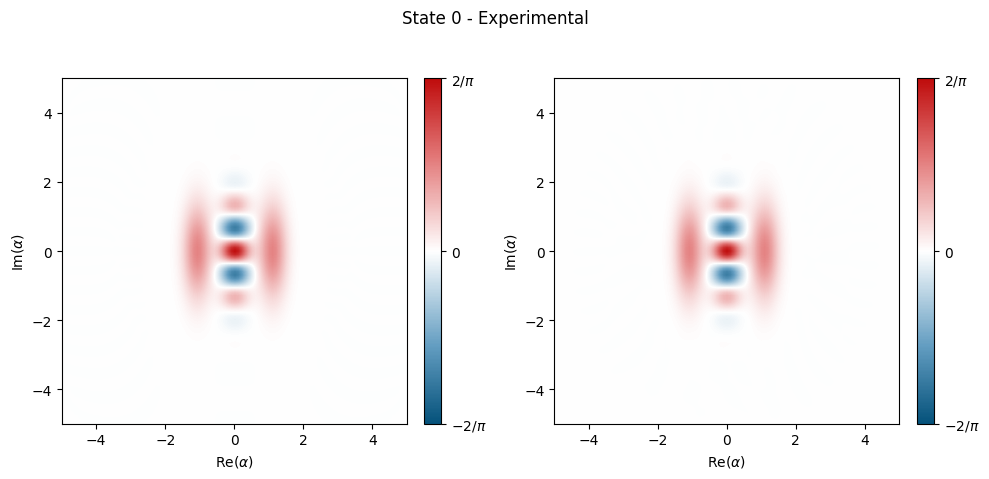

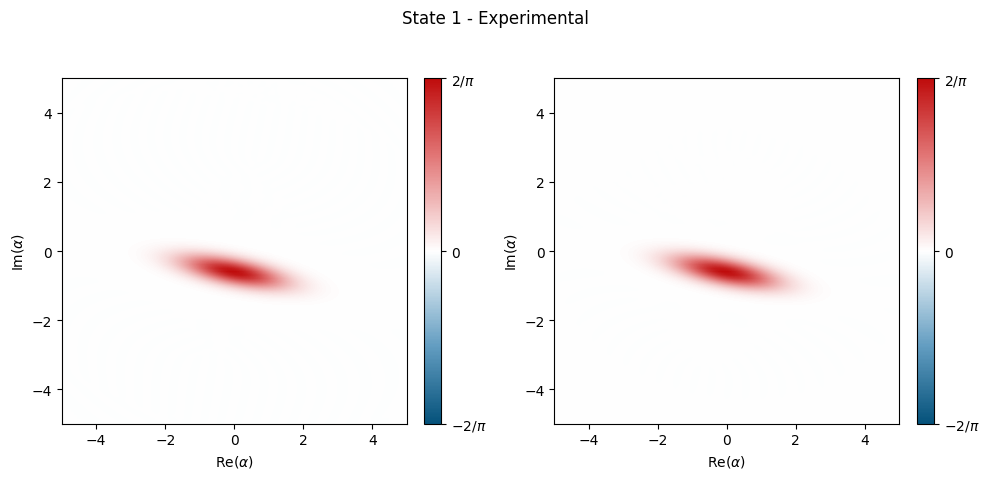

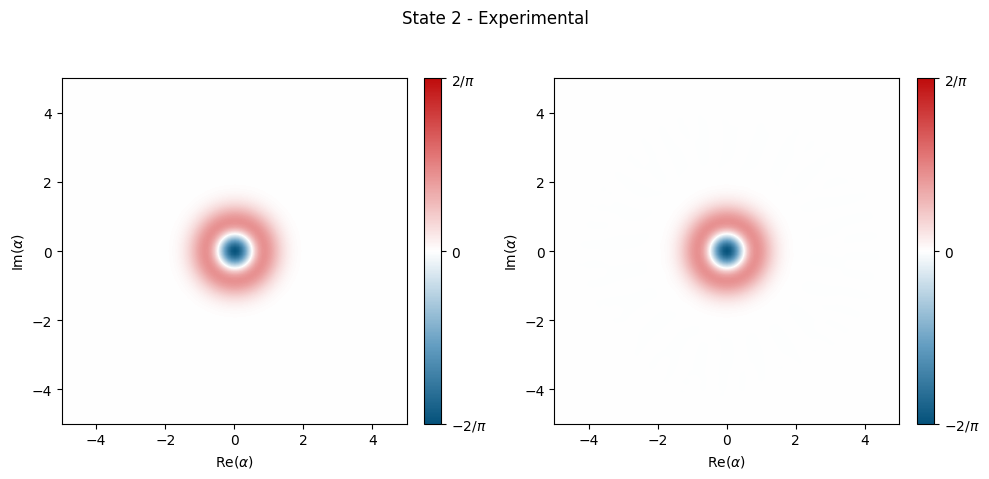

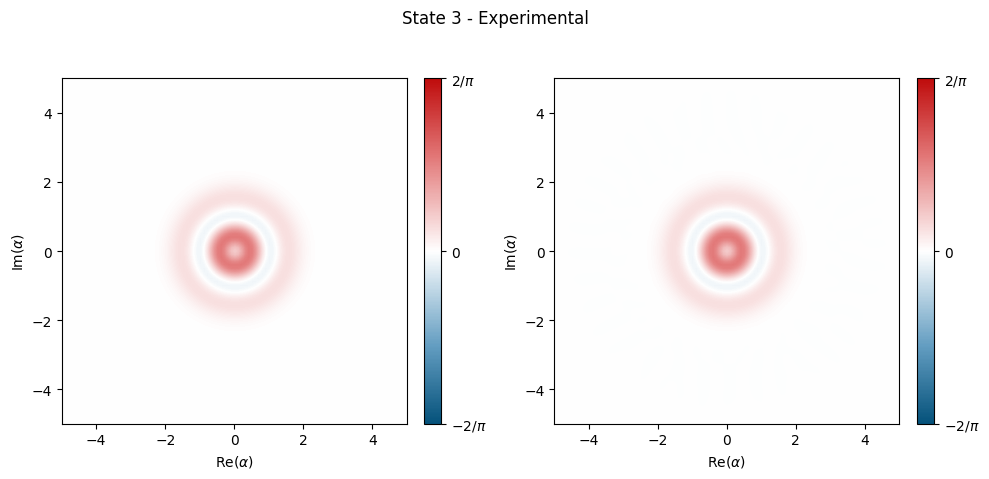

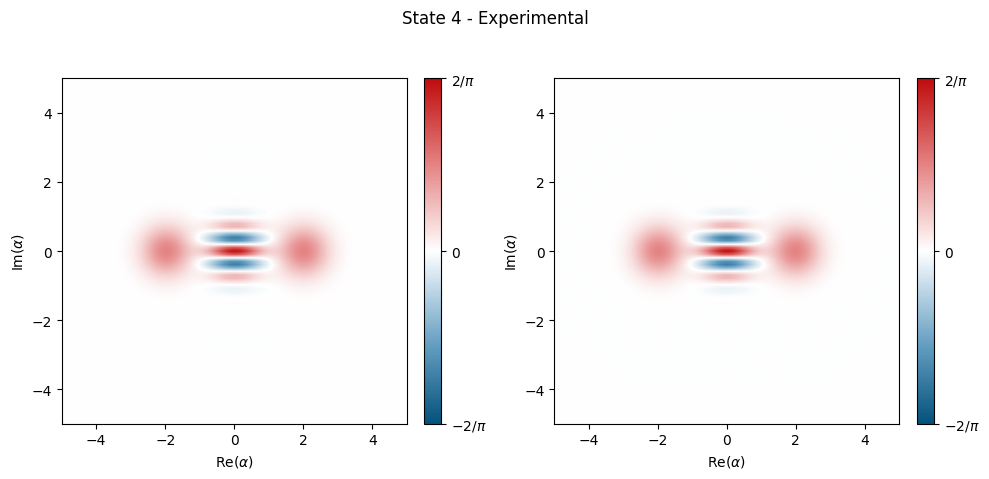

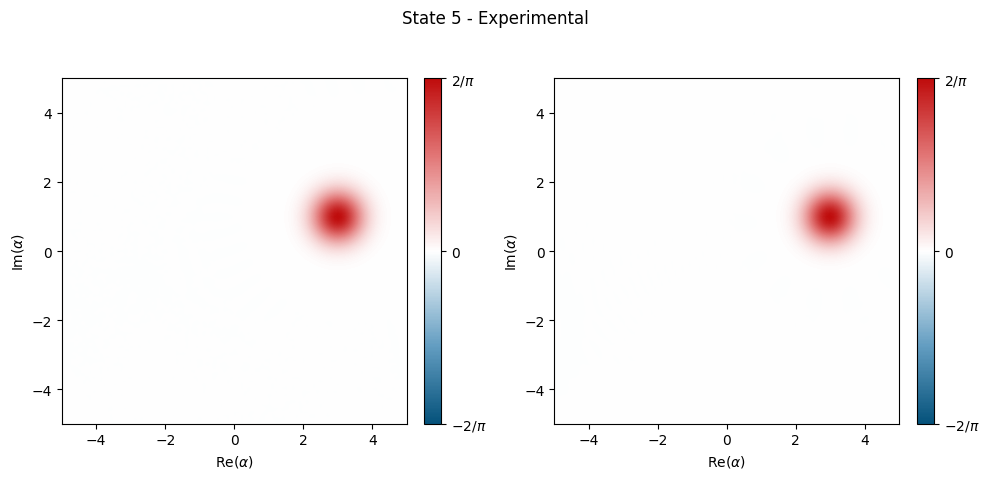

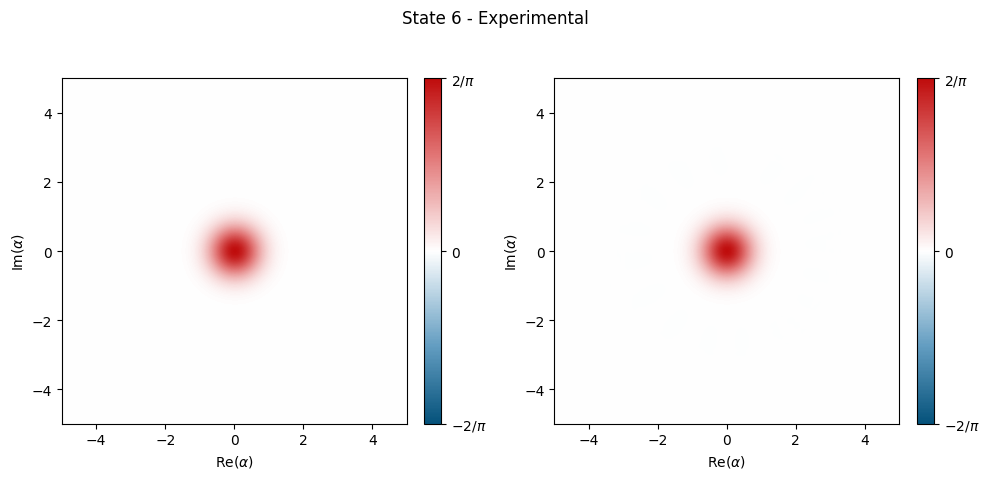

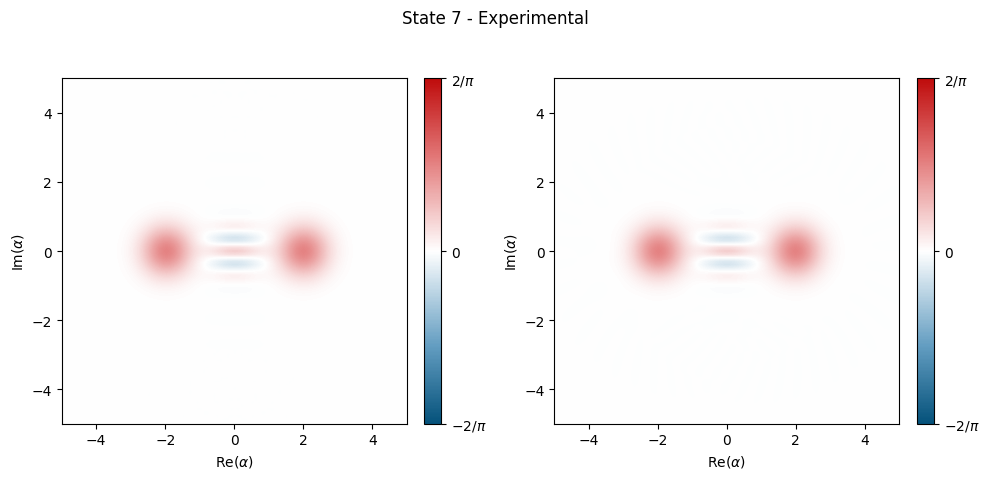

In [7]:


for i in range(len(states)):
    
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Left plot — placeholder or histogram
    dq.plot.wigner(states[i], ax=ax_left)  # Note the transpose for correct orientation

    # IMPORTANT: tell `dq.plot.wigner` to use ax_right
    dq.plot.wigner(rho_opt[i], ax=ax_right)

    # Optional title
    fig.suptitle(f"State {i} - Experimental")

    plt.tight_layout()
    plt.show()


#for i in range(len(states)):
#    dq.plot.wigner(states[i])
#    dq.plot.wigner(rho_opt[i])

---

# Task 1.C.1

In [11]:
def add_gaussian_noise(data, sigma):
    """
    Adds Gaussian noise N(0, sigma^2) to the input data.

    Parameters:
        data (np.ndarray): Input data (e.g., signal, image, etc.).
        sigma (float): Standard deviation of the Gaussian noise.

    Returns:
        np.ndarray: Noisy data.
    """
    noise = np.random.normal(0, sigma, data.shape)
    noisy_data = data + noise
    return noisy_data

In [22]:
sigma = np.linspace(0,0.2,10)
fids_noisy = []
fids_cleaned = []
overlaps_noisy = []
overlaps_cleaned = []
wig_noisies = []
rho_fits = []

for k in range(len(sigma)):
    wigner_noisy = []
    fiddis = []
    fiddis_cleaned=[]
    ovs = []
    ovs_cleaned = []
    rho_fitties = []
    for i in range(len(states)):
        x_vec, y_vec, W = wigner[i]
        W_noisy = add_gaussian_noise(W,sigma[k])
        wigner_noisy.append((x_vec, y_vec, W_noisy))
        rho_opt, fid = rho(idx=i,num_samples=100,dim_povm=50,dim_trunc=30, Filter=False, sigma=2, wigners = wigner_noisy)
        rho_opt_cleaned, fid_cleaned = rho(idx=i,num_samples=100,dim_povm=50,dim_trunc=30, Filter=True, sigma=2, wigners = wigner_noisy)
        fiddis.append(fid)
        fiddis_cleaned.append(fid_cleaned)
        ovs.append(dq.overlap(dq.dag(rho_o), states[i]))
        ovs_cleaned.append(dq.overlap(dq.dag(rho_opt_cleaned), states[i]))
        rho_fitties.append(rho_opt)
    rho_fits.append(rho_fitties)
    wig_noisies.append(wigner_noisy)
    fids_noisy.append(fiddis)
    fids_cleaned.append(fiddis_cleaned)
    overlaps_noisy.append(ovs)
    overlaps_cleaned.append(ovs_cleaned)

In [24]:
fids_by_state_noisy = [list(f) for f in zip(*fids_noisy)]
fids_by_state_cleaned = [list(f) for f in zip(*fids_cleaned)]
ovs_by_state_noisy = [list(f) for f in zip(*overlaps_noisy)]
ovs_by_state_cleaned = [list(f) for f in zip(*overlaps_cleaned)]
wig_noisies_by_state = [list(f) for f in zip(*wig_noisies)]
rho_fits_by_state = [list(f) for f in zip(*rho_fits)]

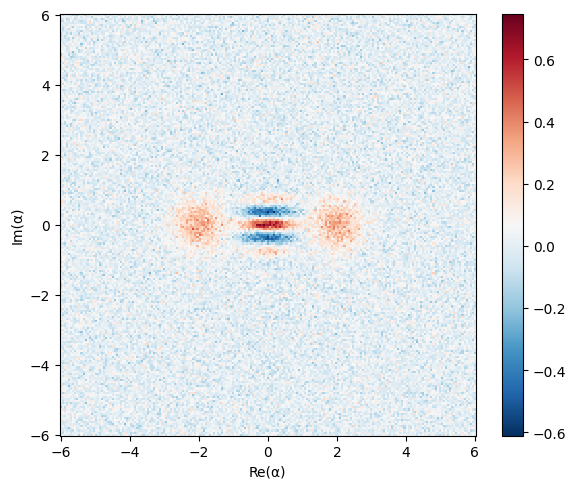

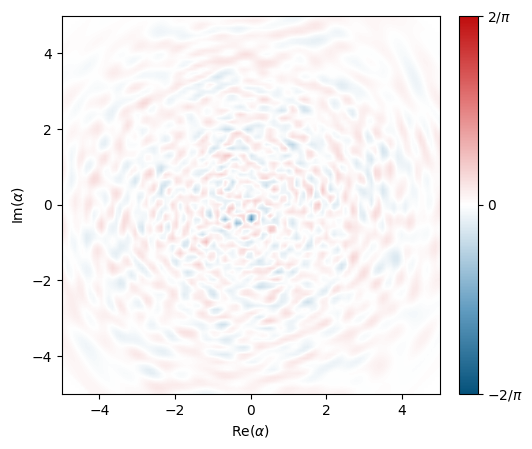

In [41]:
x = wig_noisies_by_state[4][3][0]
y = wig_noisies_by_state[4][3][1]
W = wig_noisies_by_state[4][3][2]


plt.figure(figsize=(6, 5))
plt.pcolormesh(x, y, W.T, shading='auto', cmap='RdBu_r')  # Note the transpose for correct orientation
plt.xlabel('Re(α)')
plt.ylabel('Im(α)')
#plt.title('Randomly Sampled Wigner Function')
plt.colorbar()
plt.tight_layout()
plt.show()
dq.plot.wigner(rho_fits_by_state[4][3])

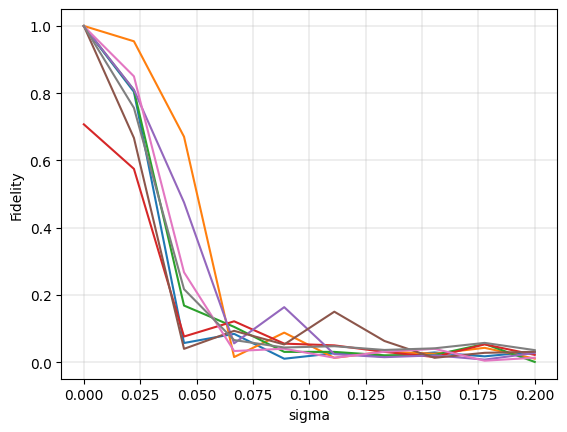

In [15]:
plt.figure()
for i in range(len(fids_by_state_noisy)):
    plt.plot(sigma, fids_by_state_noisy[i])
plt.grid(True, linewidth=0.3)
plt.xlabel('sigma')
plt.ylabel('Fidelity')
#plt.legend()
plt.show()

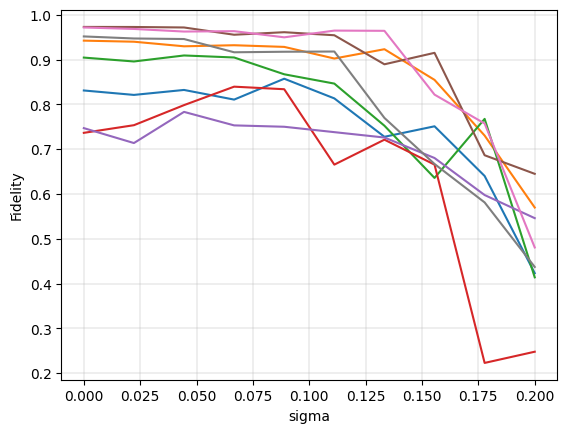

In [45]:
plt.figure()
for i in range(len(fids_by_state_cleaned)):
    plt.plot(sigma, fids_by_state_cleaned[i])
plt.grid(True, linewidth=0.3)
plt.xlabel('sigma')
plt.ylabel('Fidelity')
#plt.legend()
plt.show()

---

# Task 1.C.2

In [8]:
folder = Path('/Users/ivenwelp/Desktop/Quantum Hackathon 25/eth25_alice-bob_challenge-main/data/experimental')
if folder_path.exists() and folder_path.is_dir():
    print("Path exists!")
else:
    print("Path does not exist!")

# Find all .pkl or .pickle files in the folder
pkl_files = list(folder.glob("*.pkl")) + list(folder.glob("*.pickle"))

# Load all pickle files into a list
data_objects_experimental = []
file_names_experimental = []
for file in pkl_files:
    with open(file, "rb") as f:
        obj = pickle.load(f)
        data_objects_experimental.append(obj)
        file_names_experimental.append(file.name)

# Optional: print how many and what type of objects you loaded
print(f"Loaded {len(data_objects_experimental)} pickle files.")
print(f"Types: {[type(obj) for obj in data_objects_experimental]}")
print(f"Filenames: {file_names_experimental}")

Path exists!
Loaded 7 pickle files.
Types: [<class 'list'>, <class 'list'>, <class 'list'>, <class 'list'>, <class 'tuple'>, <class 'tuple'>, <class 'tuple'>]
Filenames: ['wigner_cat_plus.pickle', 'wigner_cat_minus.pickle', 'wigner_fock_zero.pickle', 'wigner_fock_one.pickle', 'wigner_cat_plus_25.pickle', 'wigner_cat_plus_113.pickle', 'wigner_cat_plus_56.pickle']


In [9]:
rho_opt_exp = []
fidelities_exp = []
overlaps_exp = []
wigner_exp = []
for k in range(len(file_names_experimental)):
    wigner_exp.append((data_objects_experimental[k][0], data_objects_experimental[k][1], data_objects_experimental[k][2]))
    rho_o, fidel = rho(idx=k, num_samples=1000, dim_povm=50, dim_trunc=30, Filter=True, sigma=3, wigners=wigner_exp)
    #rho_o, fidel = rho_exp(0,num_samples=300,dim_povm=50,dim_trunc=30, Filter=True, sigma=2, wigners=wigner_exp)
    rho_opt_exp.append(rho_o)

/Users/ivenwelp/miniforge3/envs/QHack2/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/Users/ivenwelp/miniforge3/envs/QHack2/lib/python3.11/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


In [10]:
Exp_N = np.trace(dq.number(50)@rho_opt_exp[0])
print(Exp_N)

(30.89963+0j)


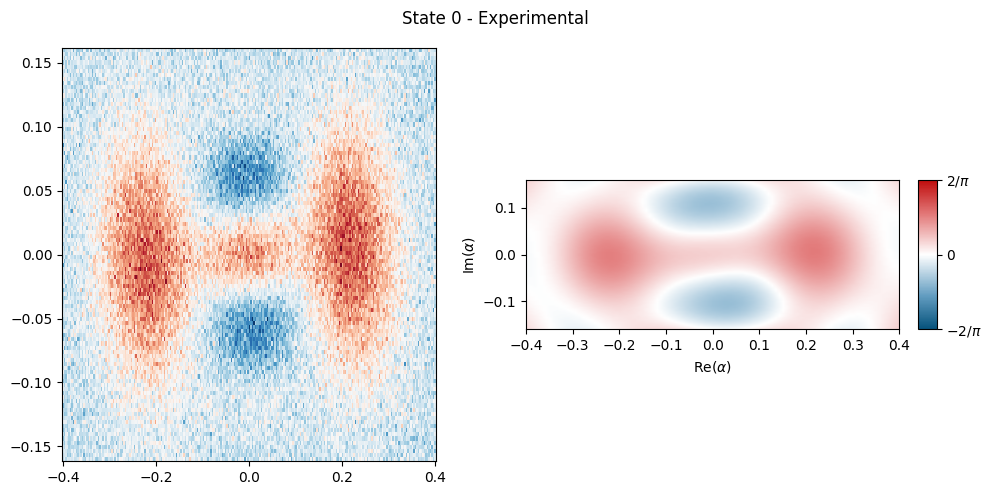

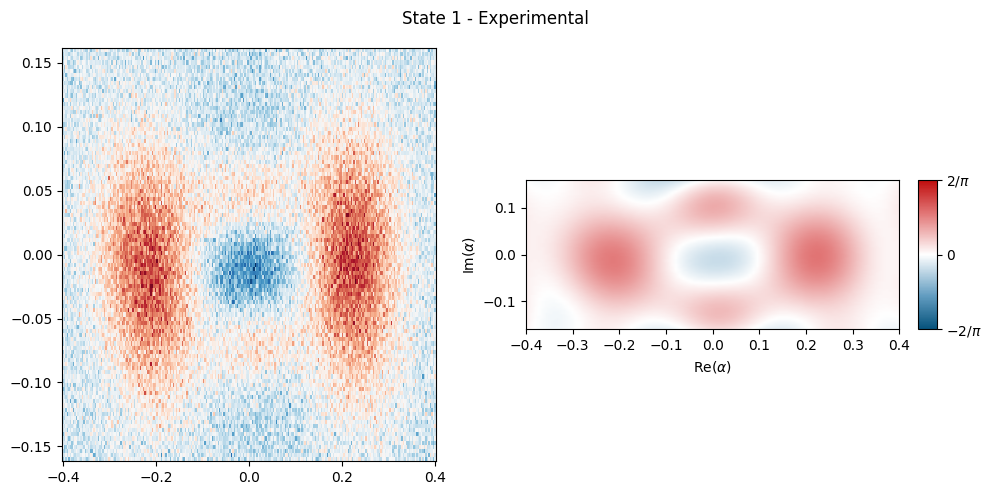

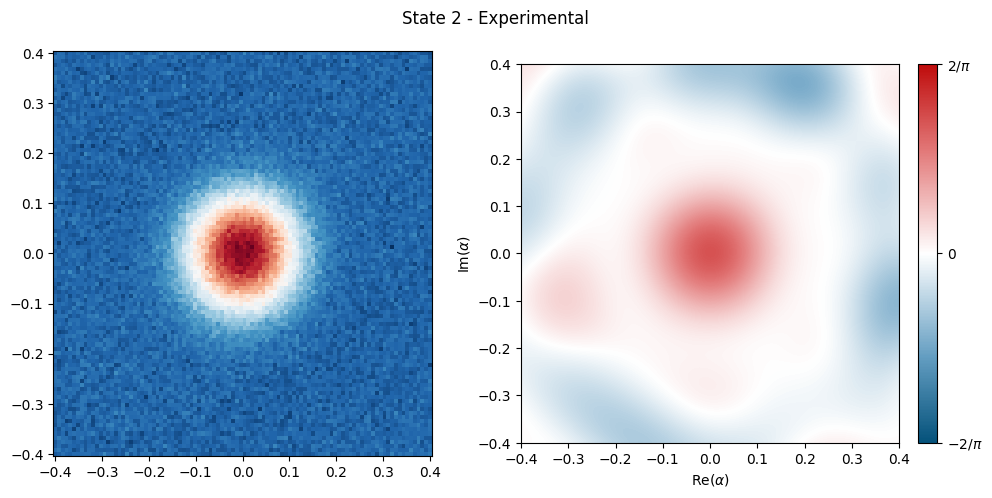

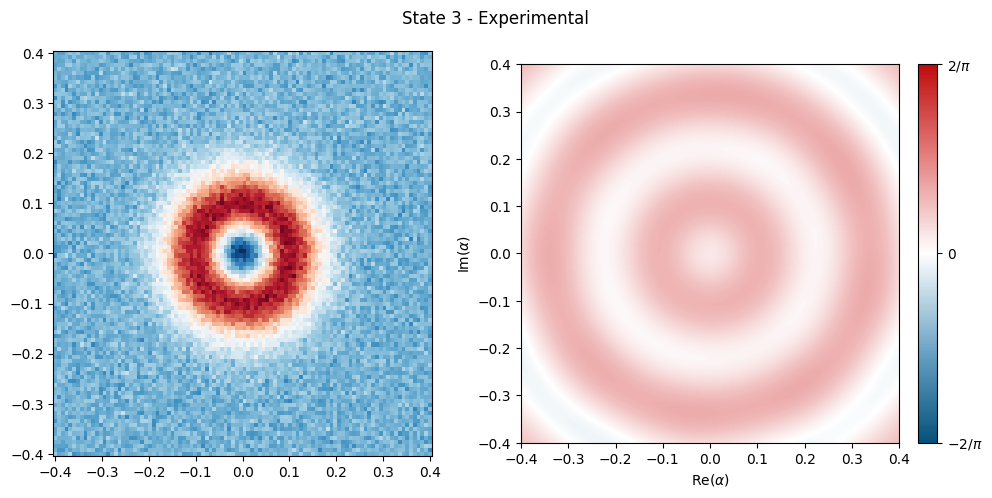

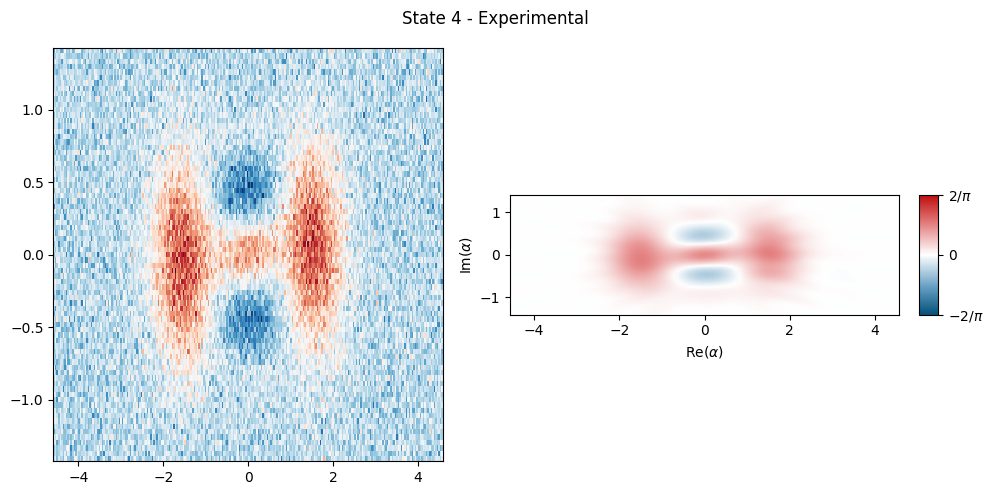

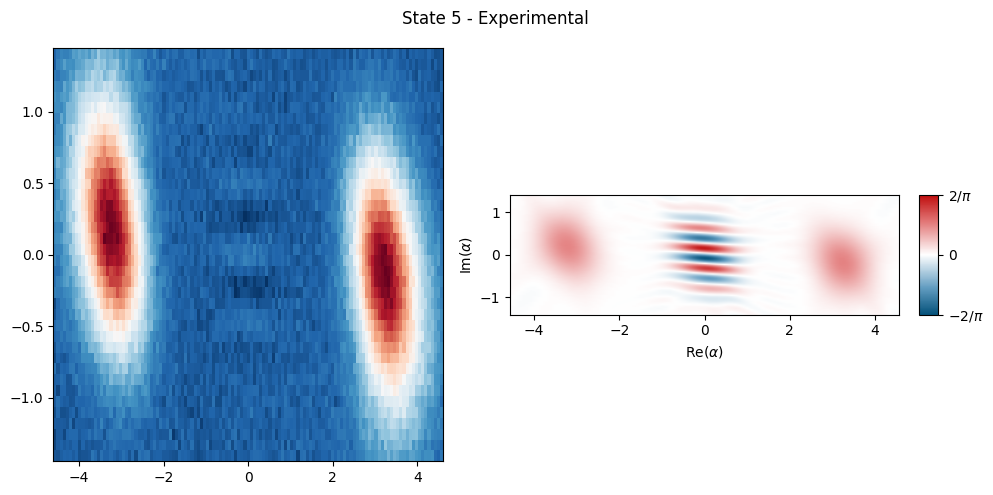

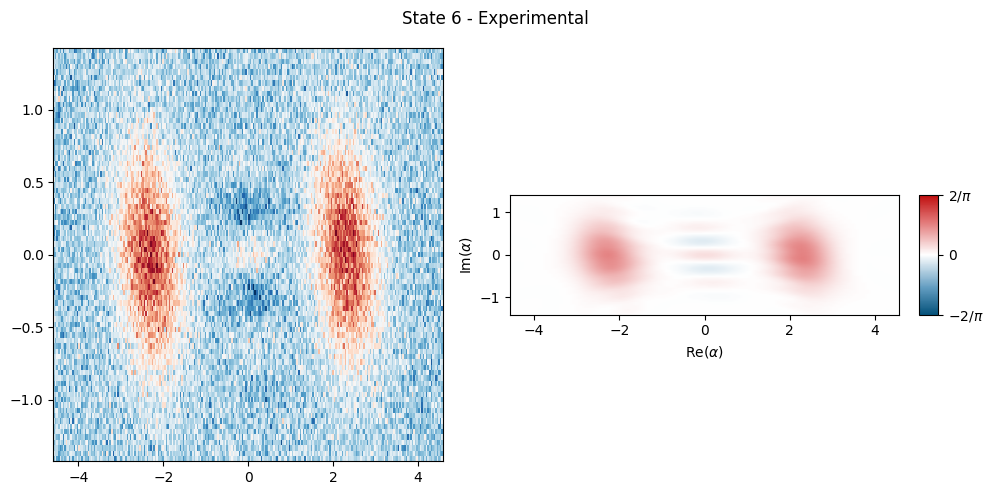

In [11]:
num_plots = len(file_names_experimental)

for i in range(num_plots):
    # Create figure with 2 subplots: left (e.g. histogram), right (Wigner)
    x = data_objects_experimental[i][0]
    y = data_objects_experimental[i][1]
    W = data_objects_experimental[i][2]
    
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Left plot — placeholder or histogram
    ax_left.pcolormesh(x, y, W.T, shading='auto', cmap='RdBu_r')  # Note the transpose for correct orientation
    
    # Right plot — Wigner function
    xmax = np.max(data_objects_experimental[i][0])
    ymax = np.max(data_objects_experimental[i][1])

    # IMPORTANT: tell `dq.plot.wigner` to use ax_right
    dq.plot.wigner(rho_opt_exp[i], xmax=xmax, ymax=ymax, ax=ax_right)

    # Optional title
    fig.suptitle(f"State {i} - Experimental")

    plt.tight_layout()
    plt.show()

In [12]:
Exp_N = []
Purity = []

for i in range(num_plots):
    Exp_N.append(np.trace(rho_opt_exp[i]@dq.number(50)))
    Purity.append(dq.purity(rho_opt_exp[i]))

In [13]:
df = pd.DataFrame({'Exp. N': np.real(Exp_N), 'Purity': Purity})
df.index.name = 'State'

# Display table
print(df)

          Exp. N      Purity
State                       
0      30.899630   0.7868593
1      30.801394   0.4094782
2      22.673359  0.11309631
3      33.405106  0.32697725
4       2.388307  0.61391175
5      10.772856   0.9998935
6       5.314468   0.5091604


---

# Monte Carlo func

In [86]:
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Try to predict the experimental states using Metropolis algorithm

def mc_rho(idx, num_samples, dim_povm, dim_trunc, max_attempts=5000, sample_threshold=1e-3):
     
    x_coarse_list = []
    y_coarse_list = []
    Wk_coarse_list = []
    alpha_samples0 = []

    for x_vec, y_vec, W_mat in wigner_exp:
        
        # Handle NaNs to smooth the Wigner function
        W_mat = np.nan_to_num(W_mat, nan=0.0)
        W_mat = np.array(W_mat)
       
        W_interp = RegularGridInterpolator((x_vec, y_vec), W_mat, bounds_error=False, fill_value=0.0)
        W_max = np.max(np.abs(W_mat))

        samples = []
        weights = []
        Wk_list = []
        alpha_samples = []
        
        attempts = 0

        # Sampling loop
        while len(samples) < num_samples and attempts < max_attempts:
            x_rand = np.random.uniform(x_vec[0], x_vec[-1])
            y_rand = np.random.uniform(y_vec[0], y_vec[-1])
            W_val = W_interp([[x_rand, y_rand]])[0]
            

            if np.random.rand() < np.abs(W_val) / W_max:
                samples.append([x_rand, y_rand])
                weights.append(np.sign(W_val))
                alpha_samples.append(x_rand + 1j * y_rand)
                Wk_list.append(W_val)
                # Store the Wigner value at the sampled point
               

            attempts += 1
        

        # If no samples found, use the localized support region
        if len(samples) == 0:
            print(f"[{idx}] ⚠️ No samples found — retrying with localized support region.")
            plt.imshow(np.abs(W_mat).T, origin="lower", extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]))
            plt.title("Support region (Absolute Wigner Function)")
            plt.colorbar(label="Wigner Function Value")
            plt.show()

            # Find a threshold value for localized sampling
            threshold_value = np.percentile(np.abs(W_mat), 90)
            support_mask = np.abs(W_mat) > threshold_value

            x_support = x_vec[np.any(support_mask, axis=1)]
            y_support = y_vec[np.any(support_mask, axis=0)]  # Define y_support
            if len(x_support) == 0 or len(y_support) == 0:
                print(f"[{idx}] No support region found. Skipping.")
                break  # Exit the loop if no support region is found

            # Define the bounding box of the support region
            x_min, x_max = x_support[0], x_support[-1]
            y_min, y_max = y_support[0], y_support[-1]

            attempts = 0
            while len(samples) < num_samples and attempts < max_attempts:
                x_rand = np.random.uniform(x_min, x_max)
                y_rand = np.random.uniform(y_min, y_max)
                W_val = W_interp([[x_rand, y_rand]])[0]
                

                if np.random.rand() < np.abs(W_val) / W_max:
                    
                    samples.append([x_rand, y_rand])
                    weights.append(np.sign(W_val))
                    alpha_samples.append(x_rand + 1j * y_rand)
                    Wk_list.append(W_val)

                attempts += 1
        
        # Store results
        x_coarse_list.append(x_vec)
        y_coarse_list.append(y_vec)
        Wk_coarse_list.append(Wk_list)
        alpha_samples0.append(alpha_samples)
   
    # Ensure the correct index is accessed from the coarse list
    Wk = np.array((Wk_coarse_list[idx]))
    wk = 0.5 * (1 + np.pi / 2 * Wk)
  
    alpha = alpha_samples0[idx]
   

    # your desired working dimension
    dim_full = dim_povm + dim_trunc
    # Generate POVM operators
    parity_full = dq.parity(dim_full)
    identity_full = dq.eye(dim_full, layout=dq.dense)
    D_alpha = dq.displace(dim_full, alpha)
    D_alpha_dag = dq.dag(D_alpha)

    displaced_parity = D_alpha @ parity_full @ D_alpha_dag
    povm_full = 0.5 * (identity_full + displaced_parity)

    # Re-wrap into a QArray with correct dims
    # Truncate manually from .data
    povm_truncated_data = povm_full.data[:, :dim_povm, :dim_povm]

    # Use as NumPy array directly
    povm_np = povm_truncated_data  # Already a NumPy array, ready for CVXPY
    # Define CVXPY variable
    rho = cp.Variable((dim_povm, dim_povm), hermitian=True)

    # Constraints: rho is PSD and trace 1
    constraints = [rho >> 0, cp.trace(rho) == 1]

    # Assume povm_np is a list or array of (dim_povm, dim_povm) NumPy arrays
    # wk is a NumPy array of measurement results (shape: (N,))
    wk_vec = np.array(wk)

    # Vectorized list of predicted values: Tr(E_i * rho) for each POVM element
    preds = cp.hstack([cp.real(cp.trace(P @ rho)) for P in povm_np])  # shape: (N,)

    #  Define least-squares objective
    objective = cp.Minimize(cp.sum_squares(preds - wk_vec))

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    # Extract solution
    rho_opt = rho.value

    return rho_opt

In [100]:
rho_mc = mc_rho(6,num_samples=5000,dim_povm=30,dim_trunc=30)

/Users/ivenwelp/miniforge3/envs/QHack2/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/Users/ivenwelp/miniforge3/envs/QHack2/lib/python3.11/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


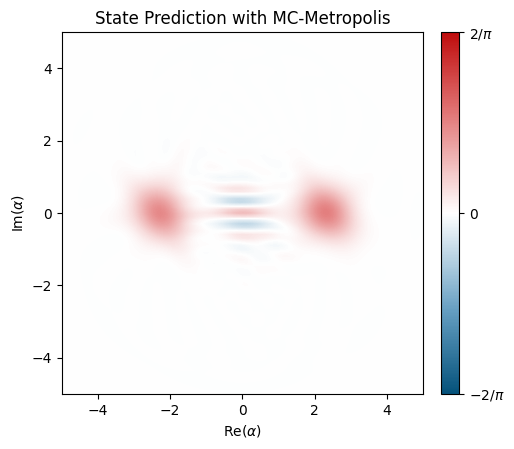

In [101]:
dq.plot.wigner(rho_mc)
plt.title('State Prediction with MC-Metropolis')
plt.savefig('Mc.png',dpi =300)